# Import and Define parameters

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import seaborn as sns

class_correspondance = {'Gluta':['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 ET', 'L5/6 NP', 'L6 CT', 'L6b'],
                       'GABA':['Pvalb', 'Sst', 'Sncg', 'Lamp5', 'Vip'], 'Astro':['Astro'], 'Oligo':['Oligo', 'OPC'],
                       'Micro':['Micro'], 'Endo':['Endo-PVM', 'Peri', 'SMC-VLMC']}

pos_cols = ['z_um', 'x_um', 'y_um']
info_cols = ['uid', 'subclass', 'MeCP2_genotype']

In [2]:
# plotting parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go

mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=10.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=8.)
mpl.rc('axes', titlesize=9.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='pdf')

mpl.rc('xtick', labelsize=7.)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=0.5)

mpl.rc('ytick', labelsize=7.)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=0.5)

mpl.rcParams['pdf.fonttype'] = 42

# Calculate volume

In [3]:
# load cells with picked DNA loci
df_cells = pd.read_csv(r"E:\DNA_analysis\Postanalysis_MeCP2\selected_all_cells.csv")
df_cells.head()

,rna_experiment,uid,fov_id,cell_id,subclass,chr,hyb,fiberidx,numfiber,MeCP2_genotype,z_um,x_um,y_um
0,20220724,315504059834584005882116425750755973090,3,100,Oligo,chr1,1,1,1,WT,7.636160,-822.088090,-913.946669
1,20220724,315504059834584005882116425750755973090,3,100,Oligo,chr1,5,1,1,WT,7.497020,-821.997755,-913.834680
2,20220724,315504059834584005882116425750755973090,3,100,Oligo,chr1,6,1,1,WT,7.907996,-822.085151,-913.055899
3,20220724,315504059834584005882116425750755973090,3,100,Oligo,chr1,7,1,1,WT,7.510613,-821.604052,-913.951513
4,20220724,315504059834584005882116425750755973090,3,100,Oligo,chr1,9,1,1,WT,7.950076,-822.104476,-913.759850


In [4]:
from scipy.spatial import ConvexHull

dict_nucleus_size = {}
for col in info_cols:
    dict_nucleus_size[col] = []
    
dict_nucleus_size['nucleus_volume_all'] = []
dict_nucleus_size['nucleus_volume_95%pts'] = []
dict_nucleus_size['total_points'] = []
dict_nucleus_size['total_chroms'] = []
dict_nucleus_size['total_fibers'] = []

for uid, df_cell in tqdm(df_cells.groupby('uid')):
    
    total_fiber = 0
    total_chrom = 0
    for chrom, df_chr in df_cell.groupby('chr'):
        total_chrom += 1
        total_fiber += df_chr['numfiber'].values[0]
    
    all_pts = df_cell[pos_cols].values
   
    dict_nucleus_size['total_chroms'].append(total_chrom)
    dict_nucleus_size['total_fibers'].append(total_fiber)

    for col in info_cols:
        dict_nucleus_size[col].append(df_cell[col].values[0])

    dict_nucleus_size['total_points'].append(len(all_pts))

    hull = ConvexHull(all_pts)
    dict_nucleus_size['nucleus_volume_all'].append(hull.volume)
    
    ### calculate the convexhull based on 95% closest pts to the center
    center_pts = np.mean(df_cell[pos_cols].values, axis=0)
    distance_to_center = np.sum(np.square(all_pts - center_pts), axis=1)
    close_pts_indices = np.argsort(distance_to_center)[:int(0.95*len(all_pts))]
    hull_95 = ConvexHull(all_pts[close_pts_indices])
    dict_nucleus_size['nucleus_volume_95%pts'].append(hull_95.volume)

df_nucleus_size = pd.DataFrame(dict_nucleus_size)
df_nucleus_size.head()

100%|███████████████████████████████████████████████████████████████████████████| 43745/43745 [01:58<00:00, 370.41it/s]


,uid,subclass,MeCP2_genotype,nucleus_volume_all,nucleus_volume_95%pts,total_points,total_chroms,total_fibers
0,100001802425095388929830403384542697355,Endo-PVM,KO,163.048461,115.616720,707,15,16
1,100011275211843700317007047959874214901,L2/3 IT,WT,184.491230,149.804210,329,9,9
2,100018691111074008062785175114987139925,L4/5 IT,WT,403.279877,332.862582,1888,19,38
3,100025410258745869509278857041962001479,L6 CT,KO,290.969813,259.297667,1205,18,26
4,100028637050868960217044968007042339849,L2/3 IT,KO,326.709693,299.365366,1472,19,28


In [5]:
############ add majortype info
subcls_to_cls = {}
for cls, subcls_list in class_correspondance.items():
    for subcls in subcls_list:
        subcls_to_cls[subcls] = cls
    
df_nucleus_size['majorType'] = df_nucleus_size['subclass'].apply(lambda x: subcls_to_cls[x])
df_nucleus_size.head()

,uid,subclass,MeCP2_genotype,nucleus_volume_all,nucleus_volume_95%pts,total_points,total_chroms,total_fibers,majorType
0,100001802425095388929830403384542697355,Endo-PVM,KO,163.048461,115.616720,707,15,16,Endo
1,100011275211843700317007047959874214901,L2/3 IT,WT,184.491230,149.804210,329,9,9,Gluta
2,100018691111074008062785175114987139925,L4/5 IT,WT,403.279877,332.862582,1888,19,38,Gluta
3,100025410258745869509278857041962001479,L6 CT,KO,290.969813,259.297667,1205,18,26,Gluta
4,100028637050868960217044968007042339849,L2/3 IT,KO,326.709693,299.365366,1472,19,28,Gluta


In [6]:
### load mouse info
df_info = pd.read_csv(r"C:\Users\cosmosyw\Documents\Research\Mecp2_v2\results\cell_composition\df_cell_with_MeCP2_genotype.csv",
                     index_col=0)
sel_cols = ['uid', 'experiment', 'hemisphere', 'WT_over_KO_ratio', 'region', 'age']
df_info = df_info[sel_cols].copy()

df_nucleus_size = df_nucleus_size.merge(df_info, left_on='uid', right_on='uid')
df_nucleus_size.head()

,uid,subclass,MeCP2_genotype,nucleus_volume_all,nucleus_volume_95%pts,total_points,total_chroms,total_fibers,majorType,experiment,hemisphere,WT_over_KO_ratio,region,age
0,100001802425095388929830403384542697355,Endo-PVM,KO,163.048461,115.616720,707,15,16,Endo,809,2,-0.830491,gray_matter,2.5_month
1,100011275211843700317007047959874214901,L2/3 IT,WT,184.491230,149.804210,329,9,9,Gluta,1027,2,-0.576206,gray_matter,6_month
2,100018691111074008062785175114987139925,L4/5 IT,WT,403.279877,332.862582,1888,19,38,Gluta,809,0,0.737448,gray_matter,2.5_month
3,100025410258745869509278857041962001479,L6 CT,KO,290.969813,259.297667,1205,18,26,Gluta,809,2,-0.830491,gray_matter,2.5_month
4,100028637050868960217044968007042339849,L2/3 IT,KO,326.709693,299.365366,1472,19,28,Gluta,724,2,-0.748815,gray_matter,2.5_month


# Plot and calculate statistics for subclasses

In [7]:
# define subclasses
subclasses = []
for _, subcls_list in class_correspondance.items():
    for subcls in subcls_list:
        subclasses.append(subcls)

In [8]:
# filter cells by total decoded points (see Materials and Methods)
df_nucleus_size_filtered = df_nucleus_size[(df_nucleus_size['total_points']>=1250)].copy()

In [9]:
# calculate statistical significance
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

dict_significance = {}
dict_significance['subclass'] = []
dict_significance['pval'] = []
dict_significance['log2fc'] = []
dict_significance['stats'] = []

for subcls in subclasses:
    df_WT = df_nucleus_size_filtered[(df_nucleus_size_filtered.MeCP2_genotype=='WT')&(df_nucleus_size_filtered.subclass==subcls)].copy()
    df_KO = df_nucleus_size_filtered[(df_nucleus_size_filtered.MeCP2_genotype=='KO')&(df_nucleus_size_filtered.subclass==subcls)].copy()
    
    wt_volumes = df_WT['nucleus_volume_all'].values
    ko_volumes = df_KO['nucleus_volume_all'].values
    
    wt_mean_vol = np.mean(wt_volumes)
    ko_mean_vol = np.mean(ko_volumes)
    
    log2fc = np.log2(ko_mean_vol/wt_mean_vol)
    
    dict_significance['subclass'].append(subcls)
    
    stat, p = mannwhitneyu(wt_volumes, ko_volumes)
    
    dict_significance['pval'].append(p)
    dict_significance['log2fc'].append(log2fc)
    dict_significance['stats'].append(stat)
    
reject, adj_p, _, _ = multipletests(dict_significance['pval'])
dict_significance['adj_p'] = adj_p

df_sig = pd.DataFrame(dict_significance)
df_sig.set_index('subclass', inplace=True)
df_sig

,pval,log2fc,stats,adj_p
subclass,,,,
L2/3 IT,2.343898e-07,-0.086540,139952.0,3.984620e-06
L4/5 IT,2.777366e-01,-0.038145,44173.0,8.580375e-01
L5 IT,4.993079e-10,-0.104868,177733.0,9.486850e-09
L6 IT,8.779526e-03,-0.045960,177460.0,9.709215e-02
L5 ET,2.350211e-06,-0.153322,19749.0,3.760272e-05
L5/6 NP,2.120882e-03,-0.125423,12897.0,2.928647e-02
L6 CT,1.640979e-10,-0.073197,837348.0,3.281957e-09
L6b,1.445132e-03,-0.160302,10371.0,2.145906e-02
Pvalb,2.156105e-03,-0.069206,24456.0,2.928647e-02


meta NOT subset; don't know how to subset; dropped


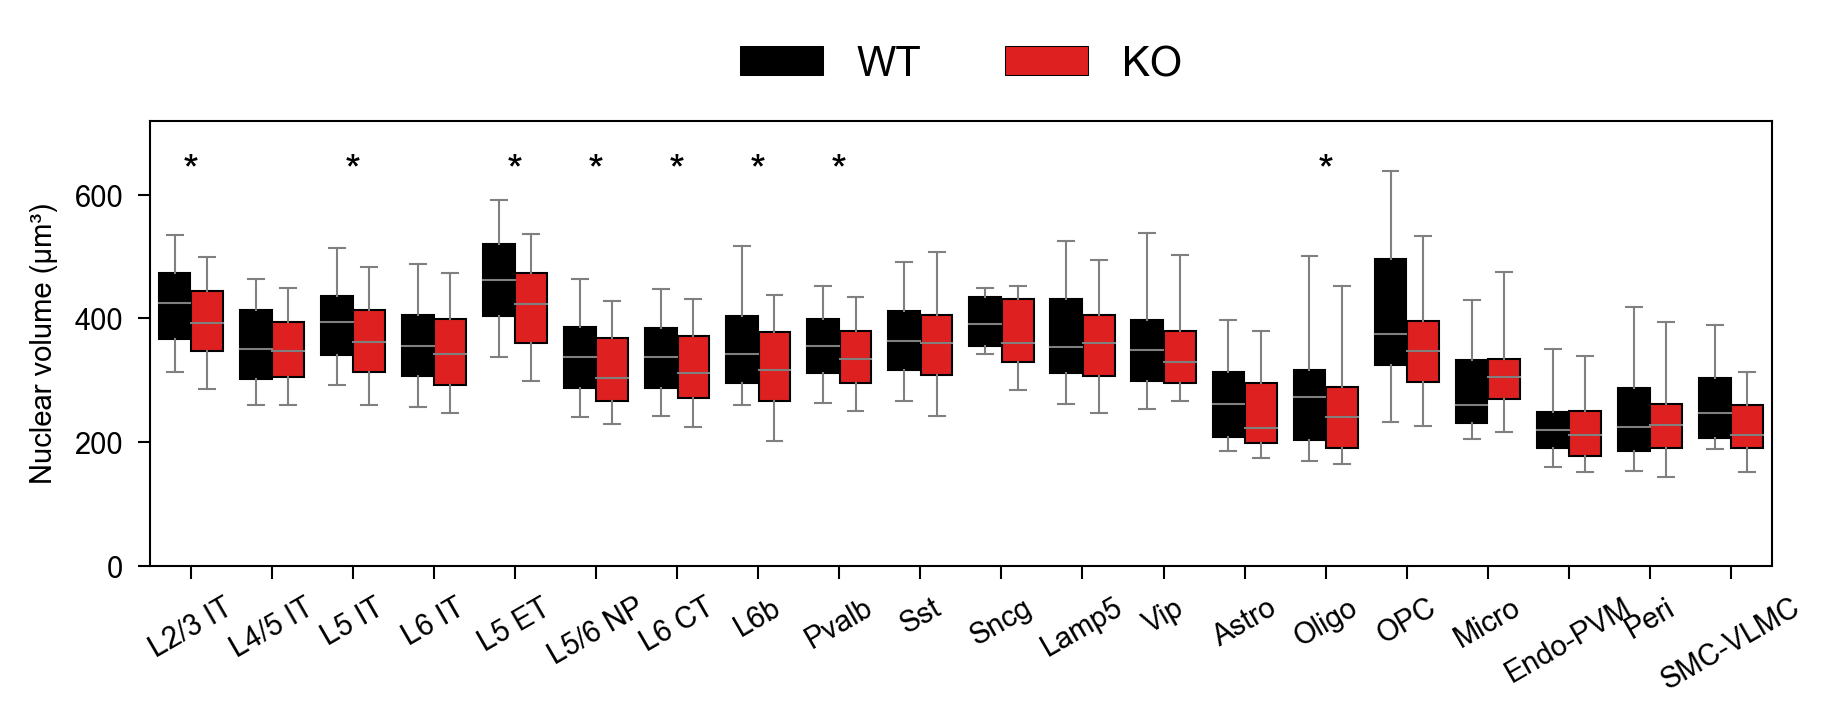

In [10]:
# plot
fig = plt.figure(figsize=(6,2.3), dpi=300)

ax = fig.add_subplot(111)

sns.boxplot(data=df_nucleus_size_filtered, x='subclass', y='nucleus_volume_all', hue='MeCP2_genotype', order=subclasses, 
            hue_order=['WT','KO'], palette={'WT':'black', 'KO':'red'}, ax=ax, fliersize=0, linewidth=0.5, whis=[5,95])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
)

ax.set_ylabel('Nuclear volume (µm³)', fontsize=7)
ax.set_xlabel(None)
ax.set_ylim(0,720)
ax.tick_params(axis='x', rotation=30)
lines = [line for line in ax.get_lines()]
for i, line in enumerate(lines):
    line.set_color('gray')

for i, subcls in enumerate(subclasses):
    if df_sig.loc[subcls,'adj_p']<=0.05:
        ax.text(i-0.1,620,'*', fontsize=10)

figure_name = 'nucleus_size_all_subclass.pdf'
plt.savefig(figure_name)

plt.show()